# COVID politics 2021

### Main ideas

Did people react differently to COVID-19 depending on their political beliefs?
(Does it generate more controversy than other topics controversy?)

This notebook intends to visualize if such relationship exists, and if so, quantify it.

The study is focused in the US due to two main factors:
 - Data availability
 - "Simplified" political landscape
 
### Introduction 
 
It is impossible to separate now 2020 to the pandemic. Despite the certain feeling that COVID-19 paralyzed the world, the pandemic itself has been far from still. The relentless spread of the virus has taken many forms inside ourselves: what is going on in Wuhan? What is going in Italy? How long will the lockdown last? Are masks effective? Which company is making the vaccine? The urgency and total presence of such topics have modified our discussions and the way we discuss them. Speaking of discussing, could the mental takeover be different depending on your political views?

In order to check this, first we will investigate the headlines in the subreddit r/Coronavirus, to discern the main relevant topics that have flooded our conversations during 2020. Then, identifying the clusters of words that are representative from that topic in particular, we can look them up un forums intended to political discussion. In this case, we take advantage of the community based structure of reddit to compare the evolution and impact of those topic in r/republican and r/democrats.


## Data sources

https://reddit-api.readthedocs.io/en/latest/
https://electionlab.mit.edu/data
https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX

https://reddit-api.readthedocs.io/en/latest/#comments-search

Color candidates:eggplant (#614051), mountbatten pink (#997a8d)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime as dt
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import multiprocessing
from itertools import product

from collections import Counter
from wordcloud import WordCloud, get_single_color_func
from os import path


from sklearn.feature_extraction.text import TfidfVectorizer
#Import LDA topic modelling plugin from sklearn
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.sklearn

# Importing local functions
from COVID_functions import *

pd.options.mode.chained_assignment = None

from colour import Color

from scipy import interpolate
from copy import deepcopy
from scipy.interpolate import interp1d


In [2]:
data_folder = '/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/data/posts/submissions/coronavirus/'

metadf1_column_titles = ['created_utc',
          'author',
          'subreddit',
          'score',
          'id',
          'title',
          'num_comments',
          'num_crossposts',
          'subreddit_subscribers',
          'author_flair_text',
          'author_flair_type']

In [3]:
#time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(praw_submission.created_utc))

# creating empty elements
metadat0 = pd.DataFrame(columns = metadf1_column_titles)
meta_file_path = data_folder + 'metadata1.txt'

metadat0 = pd.read_csv(meta_file_path, sep='\t', header = None, names = metadf1_column_titles)
metadat0['TimeStamp'] = pd.to_datetime(metadat0['created_utc'], unit = 's')
metadat0['date'] = metadat0['TimeStamp'].dt.date
metadat0['period'] = metadat0['TimeStamp'].astype('int')//(1e9*60*60*24*1)
metadat0['period'] = metadat0['TimeStamp'].dt.dayofyear

dc19 = metadat0[metadat0['TimeStamp'].dt.year.isin([2020])]
dc19['hour'] = dc19['TimeStamp'].dt.hour

dc19 = dc19[dc19.period > 22]

dc19['tokens'] = dc19.title.apply(tokenizer)

dc19.head(5)

,created_utc,author,subreddit,score,id,title,num_comments,num_crossposts,subreddit_subscribers,author_flair_text,author_flair_type,TimeStamp,date,period,hour,tokens
3,1579760266,blackie6644,Coronavirus,1,esp4td,"how people in Wuhan eat roast bats, bat sushi,...",8,0,162,None,text,2020-01-23 06:17:46,2020-01-23,23,6,"[wuhan, eat, roast, bat, bat, sushi, bat, soup..."
4,1579742601,blocketjoe,Coronavirus,1,eslqng,China Is On Lockdown Due To Corona Virus!,3,0,130,None,text,2020-01-23 01:23:21,2020-01-23,23,1,"[china, lockdown, due, corona]"
5,1579773673,Silver_Linings_89,Coronavirus,1,esqzz1,Modeling the spread of diseases like the Coron...,0,0,206,None,text,2020-01-23 10:01:13,2020-01-23,23,10,"[model, spread, diseas]"
6,1579774394,SealDrop,Coronavirus,1,esr4as,CORONA VIRUS MEMES,1,0,209,None,text,2020-01-23 10:13:14,2020-01-23,23,10,"[corona, meme]"
7,1579740470,bipboop11,Coronavirus,1,esla8o,Disease control questions,10,0,125,None,text,2020-01-23 00:47:50,2020-01-23,23,0,"[diseas, control, question]"


In [4]:
#Instatiate TFIDF Vectorizer
tfidf = TfidfVectorizer(tokenizer = tokenizer,
                            # min_df = 365,
                          min_df = 0.02125, 
                           analyzer='word',
                           ngram_range = (1,1))

#dc19.comments is referring to the text column from my dataframe containing the comments
token_matrix = tfidf.fit_transform(dc19.title)

#If you would like to store the matrix to a dataframe, execute the code below
matrix_df = pd.DataFrame(token_matrix.toarray(), columns = tfidf.get_feature_names())

#I'm looking for the top n words for each topic
token_names = tfidf.get_feature_names()

In [255]:
from bokeh.layouts import gridplot, layout, Spacer, row, column
from bokeh.models.annotations import Title
from bokeh.models import ColumnDataSource, Legend, Rect, LegendItem, Span, Arrow, NormalHead, OpenHead, VeeHead
from bokeh.models import BoxAnnotation, Label, InvertedTriangle, Text, Triangle, Line, ImageURL, Image, VArea, Step
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.models import HoverTool, TapTool, MultiLine
from bokeh.plotting import figure, output_file, show, output_notebook, save, show
from bokeh.io import show
from bokeh.embed import components
from bokeh.core.properties import value

from bokeh.io import export_svgs


from bokeh.palettes import Category20
from bokeh.io import output_file, reset_output

from bokeh.io import export_png

# Settting the figure object
output_notebook()

Loading BokehJS ...

In [6]:
def CountWord(title, word):
    
    from collections import Counter 
    
    tokens = tokenizer(title)
    
    c = Counter(tokens)
    
    if word in c.keys():
        return c[word]
    else:
        return 0

In [7]:
from localreg import *

controversy_topics = token_names

for w_i in controversy_topics:
    dc19[w_i] = dc19.title.apply(lambda x: CountWord(x, w_i))
    
datest = dc19[['period'] + controversy_topics].groupby('period').agg(np.sum)
datest = datest.join(dc19[['period','TimeStamp']].groupby('period').agg(min), how= 'outer')
datest['date'] = datest.TimeStamp.dt.strftime('%d-%b-%y')

In [8]:
datest = datest.reset_index()

for w in controversy_topics:
    name_sm = '_'.join([w,'ks'])
    x = datest.index.to_numpy()
    y = datest[w].to_numpy()
    datest[name_sm] = localreg(x, y, x0 = x, kernel=rbf.epanechnikov, width=14, frac=None)
    
###
datest0 = datest
###

ndays0 = 23
IniYear = {}
for col in datest.columns:
    IniYear[col] = [0 for _ in range(ndays0)]

dfiniyear = pd.DataFrame.from_dict(IniYear,orient='index').transpose()
datest = pd.concat([dfiniyear, datest])

datest.head()

,period,china,confirm,death,die,health,hospit,infect,lockdown,mask,...,outbreak_ks,pandem_ks,patient_ks,posit_ks,record_ks,report_ks,spread_ks,studi_ks,test_ks,vaccin_ks
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


REMEMBER TO SAVE!!!

The subreddit of Covid starts around day 20 of January, so we add 0s in front

In [9]:
TOOLTIPS_title = """
    <div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@date</span>
        </div>
        <div style="width:200px; height: 30%;">
            <span style="font-size: 13px; color: #966;">@title</span>
        </div>
    </div>
"""


c1 = 'salmon'
c2 = '#7a28cb'
c3 = '#8C7284'
c4 = ''


In [10]:
cneut = '#820872'

In [ ]:
# Folder to save the web images
img_folder = '/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/web/'


In [300]:
from COVID_functions import *

# Generate rest
List_of_plots = []
Nr = 19

for indx,word_i in enumerate(controversy_topics[1:]):
    
    
    dfi = CreateDfRelevant(word_i, Nr, dc19, datest)
    
    p_i = CreateCalendarPlot(word_i, dfi.index.tolist(), dfi.title.tolist(), col = cneut,  width = 400)
    
    # curtain rectangle
    r_rect = p_i.rect(x=-100, y = -100, height = 1000, width = 1000, fill_color = 'white', fill_alpha = 1)
    hover3 = HoverTool(tooltips = None,renderers = [r_rect], mode = 'mouse')
    p_i.tools.append(hover3)
    selected_rect = Rect(fill_alpha=0., fill_color = 'white')
    r_rect.hover_glyph = selected_rect
    
    p_i = AddText(p_i, (37/2, 10/2),word_i, '40pt', 'grey')
    
    List_of_plots.append(p_i)
    
p_all = gridplot(List_of_plots, ncols=3)

word_i = controversy_topics[0]
dfi = CreateDfRelevant(word_i, Nr, dc19, datest)   
p1 = CreateCalendarPlot(word_i, dfi.index.tolist(), dfi.title.tolist(), width = 640, ms = 10, col = cneut)
p1 = AddText(p1, (37/2, 10/2),word_i, '60pt', 'grey')


calendar_rows = 10
calendar_cols = 37

side_plot = int(np.floor(540*(calendar_rows/calendar_cols)))
p_legend = figure(plot_width=400, plot_height=side_plot, title = None, tools = '',
                   x_range=(0,1), y_range = (0,1))
p_legend.square([0.5],[0.5], fill_alpha = 1, fill_color = cneut, line_color = cneut, size = 0, legend_label='Relevant post mentioning "china"')
p_legend.inverted_triangle([0.5],[0.5], line_alpha = 0, fill_alpha = 1, fill_color = 'black', line_color = 'black',size = 0, angle = np.pi/2, legend_label='01-Jan-2020')
p_legend.triangle([0.5],[0.5], line_alpha = 0, fill_alpha = 1, fill_color = 'black', line_color = 'black',size = 0, angle = -np.pi/2, legend_label='31-Dec-2020')
p_legend.x([0.5],[0.5], line_alpha = 1, size = 0, legend_label='End of calendar', line_color = 'black')

p_legend = empty_canvas(p_legend)

p_legend.legend.location = "top_left"
p_legend.legend.border_line_width = 0
p_legend.legend.label_text_font_size = '16pt'



output_file(filename=img_folder + "CALENDAR_PLOT.html", title="")
save(layout([gridplot([p1,p_legend], ncols = 2), [p_all]]))

'/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/web/CALENDAR_PLOT.html'

bump plotting
https://www.kaggle.com/markalec/olympics-streams-and-bumps-charts-in-python

tapping and selecting multilines
https://discourse.bokeh.org/t/programmatic-highlighting-with-multiple-renderers/3648/3

In [12]:
datest = datest.reset_index()

In [13]:
first_week = datest[controversy_topics + ['index']].groupby(['index']).agg(np.sum).loc[1]

In [14]:
dfweek1 = pd.DataFrame(first_week).reset_index()
dfweek1 = dfweek1.rename(columns = {'index' : 'word', 1:'count'})
dfweek1 = dfweek1.sort_values(by='count')
controversy_topics_sorted = dfweek1.word.tolist()

In [295]:
output_file(filename=img_folder + "RANKING_PLOT.html", title="")

p_rank, dict_multi_covid = CreateRankingPlot(datest,
                                             controversy_topics_sorted,
                                             col1 = 'skyblue',
                                             col2 = cneut, 
                                             col3 = 'goldenrod')

p_rank.title.align = 'right'
p_rank.title.text_color = 'black'
save(p_rank)

/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/COVID_functions.py:34: DeprecationWarning: invalid escape sequence \y
  awkward_sep = '_/zvzvzvzv/EndOfElement\yxyxyxy\_'


'/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/web/RANKING_PLOT.html'

There is two peaks talking about confirmation: one for wuhan, and another one when the virus spread globally. As soon as the second peak starts, the word china fades. Similarly, the word _test_ matches the confirmation peak.

There are two major pleateau in the word _lockdown_...

Hospitals peak before and after hospitals. _Hospitals_ is correlated with _record_ during the second half of 2020.

The word _spreading_ has been decreasing slightly with only minor peaks. This also applies to _outbreak_.

The mask discussion peaked during the summer.

You can see the delay in the use of the word studi...



# Comparing political response

Reading the comments on the republicans and democrat subreddits

In [16]:
dfdem = ReadSubreddit('democrats')
dfrep = ReadSubreddit('republican')

N_rep = dfrep.shape[0]
N_dem = dfdem.shape[0]

In [17]:
 def COVIDwordIndex(string):
   
    return sum([int(x in string)/len(token_names) for x in token_names])

In [18]:
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default

comments_ = dfrep.comments.tolist()

all_comments = ' '.join(comments_)

n_comments = len(comments_)
num_topics = len(controversy_topics)

pool = multiprocessing.Pool(processes=cpus)
matrix_list = pool.starmap(CountWord, product(comments_,controversy_topics))

matrix_probs = np.array(matrix_list)
shape = (n_comments, num_topics)
matrix_df = pd.DataFrame(matrix_probs.reshape(shape))
matrix_df.columns = controversy_topics

dfrep = pd.concat([dfrep.reset_index(), matrix_df.reset_index()], axis=1)

In [19]:
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default

comments_ = dfdem.comments.tolist()

all_comments = ' '.join(comments_)

n_comments = len(comments_)
num_topics = len(controversy_topics)

pool = multiprocessing.Pool(processes=cpus)
matrix_list = pool.starmap(CountWord, product(comments_,controversy_topics))

matrix_probs = np.array(matrix_list)
shape = (n_comments, num_topics)
matrix_df = pd.DataFrame(matrix_probs.reshape(shape))
matrix_df.columns = controversy_topics

dfdem = pd.concat([dfdem.reset_index(), matrix_df.reset_index()], axis=1)

In [20]:
rel_columns = ['month', 'comments','TimeStamp'] + controversy_topics

topww = dfrep[rel_columns].groupby(['month']).agg(np.sum).reset_index()
topww1 = dfdem[rel_columns].groupby(['month']).agg(np.sum).reset_index()

In [21]:
dfrep['tokens'] = dfrep.comments.apply(tokenizer)
dfdem['tokens'] = dfdem.comments.apply(tokenizer)

dfdem['covidcoef'] = dfdem.comments.apply(COVIDwordIndex)
dfrep['covidcoef'] = dfrep.comments.apply(COVIDwordIndex)

In [176]:
dfdem = dfdem.drop(dfdem[dfdem.author == 'AutoModerator'].index)
dfrep = dfrep.drop(dfrep[dfrep.author == 'AutoModerator'].index)

### Are coronawords treated different than others??

NEED TO COUNT valid WORDS/TOKENS, with len(), I am counting letters

In [22]:
crep = 'tomato'
cdem = 'dodgerblue'

crep = '#EC080E'
cdem = '#1C81D5'

In [177]:
dfdem_agg = dfdem[['day'] + controversy_topics].groupby('day').agg(np.sum)
dfrep_agg = dfrep[['day'] + controversy_topics].groupby('day').agg(np.sum)

for w in controversy_topics:
    
    name_sm = '_'.join([w,'ks'])
    # Republican
    x = dfdem_agg.index.to_numpy()
    y = dfdem_agg[w].to_numpy()
    dfdem_agg[name_sm] = localreg(x, y, x0 = x, kernel=rbf.epanechnikov, width=14, frac=None)
    # Democrat
    x = dfrep_agg.index.to_numpy()
    y = dfrep_agg[w].to_numpy()
    dfrep_agg[name_sm] = localreg(x, y, x0 = x, kernel=rbf.epanechnikov, width=14, frac=None)
    
WordSizes = {}
max_size = 0
for w in controversy_topics:
    s_dem = dfdem[w].sum()/N_dem
    s_rep = dfrep[w].sum()/N_rep
    WordSizes[w] = {'dem' : s_dem, 'rep' : s_rep}
    max_size = max([max_size, s_dem, s_rep])

    
sizes_dem = [WordSizes[w]['dem']/max_size for w in controversy_topics]
sizes_rep = [WordSizes[w]['rep']/max_size for w in controversy_topics]

In [291]:
from bokeh.models import Toggle

p1p2 = []
colors_repdem = {'rep' : crep, 'dem' : cdem}
sr_name = {'rep' : 'r/republican', 'dem' : 'r/democrats'}

Buttons = []

p1 = figure(plot_width= 620, plot_height=620, title = None,
            x_range=(-0.1,1.3),y_range = (-0.1,1.3), tools = '', tooltips = None)

for p in ['rep','dem']:
       
#     text_i = sr_name[p]
#     text1 = Text(x='x', y='y', text="text", text_font_size = '14pt', text_font_style = 'bold',
#                  text_color = 'grey', text_baseline = 'top', text_align = 'left')
#     r_text = p1.add_glyph(ColumnDataSource(dict(x=[0.155], y=[0.54], text=[text_i])), text1) 

    side1 = np.sqrt(sum([WordSizes[w][p] for w in controversy_topics]))
    rect1 = p1.rect(x=side1/2, y = side1/2, height = side1, width = side1,
                    fill_color = colors_repdem[p], fill_alpha = 1, 
                    line_width = 2, line_color = colors_repdem[p], line_alpha = 1)
    
    toggle1 = Toggle(label=sr_name[p], button_type="default", active=True, default_size = 150)
    toggle1.js_link('active', rect1, 'visible')
    Buttons.append(toggle1)

text1 = Text(x='x', y='y', text="text", text_font_size = '16pt', y_offset = 5, x_offset = 5, 
              text_color = 'black', text_baseline = 'top', text_align = 'left')

text_i = '100% of posts\nin subreddit'
r_text = p1.add_glyph(ColumnDataSource(dict(x=[0.0], y=[1.0], text=[text_i])), text1)

text_i = '50% of posts\nin subreddit'
r_text = p1.add_glyph(ColumnDataSource(dict(x=[0.0], y=[np.sqrt(0.5)], text=[text_i])), text1)


text2= Text(x='x', y='y', text="text", text_font_size = '18pt', y_offset = 5, x_offset = 5, 
              text_color = 'black', text_baseline = 'top', text_align = 'left', text_font_style = 'bold')
text_i = 'Fraction of comments\nwith a COVID word'
r_text = p1.add_glyph(ColumnDataSource(dict(x=[0.0], y=[1.15], text=[text_i])), text2)


side50 = np.sqrt(0.5)
p1.rect(x=side50/2, y = side50/2, height = side50, width = side50,
        fill_color = None, fill_alpha = 1, line_dash = 'dashed', 
        line_width = 1, line_color = 'black', line_alpha = 1)

side100 = np.sqrt(1)
p1.rect(x=side100/2, y = side100/2, height = side100, width = side100,
        fill_color = None, fill_alpha = 1, line_dash = 'solid', 
        line_width = 1, line_color = 'black', line_alpha = 1)
    
    
p1.xaxis.axis_label = ""
p1.yaxis.axis_label = ""
p1.xaxis.visible = False
p1.yaxis.visible = False

p1.grid.ticker = np.linspace(0,1,11)
p1.grid.visible = False

p1.background_fill_alpha = 1

p1.outline_line_color = None

#p1.outline_line_dash = 'solid'

#p1.background_fill_color = "seashell"

p_footprint = column(p1, row(Buttons))

output_file(filename=img_folder + "CORONA_FOOTPRINT.html", title="")
save(p_footprint)


'/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/web/CORONA_FOOTPRINT.html'

In [282]:
List_of_plots = []
xrep = range(dfrep_agg.shape[0])
xdem = range(dfdem_agg.shape[0]) 

dictdem = {'x' : xdem}
dictrep = {'x' : xrep}

for indx,w_i in enumerate(controversy_topics):
        
    s0 = sizes_rep[indx]
    s1 = sizes_dem[indx]

    scale = 80
    fontsize0 = ''.join([str(scale*s0), 'pt'])
    fontsize1 = ''.join([str(scale*s1), 'pt'])

    
        # smooth trend??
    name_sm = '_'.join([w_i,'ks'])
    
    bars_rep = [max([y/(dfrep_agg.shape[0]),0]) for y in dfrep_agg[w_i]]
    bars_dem = [max([y/(dfdem_agg.shape[0]),0]) for y in dfdem_agg[w_i]]
    
    ysm_rep = [max([y/(dfrep_agg[name_sm].sum()),0]) for y in dfrep_agg[name_sm]]
    ysm_dem = [max([y/(dfdem_agg[name_sm].sum()),0]) for y in dfdem_agg[name_sm]]
    
    maxy = 1.07*max(ysm_rep+ysm_dem)
    miny = -0.07*max(ysm_rep+ysm_dem)
    
    minx = 1
    maxx = 365
    
    xcenter = (maxx-minx)/2
    ycenter = (maxy-miny)/2
    
    p1 = figure(plot_width= 450, plot_height=85,title = None,
               x_range=(minx,maxx),y_range = (miny,maxy), tools = '', tooltips = None)
    
    label0 = Label(x=xcenter, y=ycenter, text=w_i, text_font_size = fontsize0, text_color = crep,
                    border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                    background_fill_color=None, background_fill_alpha=1.0,
                    text_baseline = 'middle', text_align = 'center',
                    level='overlay')
    label1 = Label(x=xcenter, y=ycenter, text=w_i, text_font_size = fontsize1, text_color = cdem,
                    border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                    background_fill_color=None, background_fill_alpha=1.0,
                    text_baseline = 'middle', text_align = 'center',
                    level='overlay')
    
    # Dummy circle
    p1.circle([],[])
        
    p1.add_layout(label0)
    p1.add_layout(label1)  

    # Adjusting plot parameters
    p1.xaxis.axis_label = ""
    p1.yaxis.axis_label = ""
    p1.xaxis.visible = False
    p1.yaxis.visible = False
    p1.grid.visible = False
    p1.background_fill_alpha = 1
    
    p1.outline_line_color = None
    p1.background_fill_color = None
    p1.border_fill_color = None
    
    p1.background_fill_color = None
    
    List_of_plots.append(p1)
    
    p1.output_backend = 'svg'
    
    dictdem[w_i] = bars_dem
    dictrep[w_i] = bars_rep
    

# Saving 
output_file(filename=img_folder + "WORDS_BY_COMMUNITY.html", title="")

p_all = gridplot(List_of_plots, ncols=3)
#p_all.output_backend = 'svg'
#show(p_all)

save(p_all)

'/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/web/WORDS_BY_COMMUNITY.html'

The size of the previous words reflect the yearly volume of use (normalized by the number of comments in each subreddit).

However, it is important to see if these words are treated similarly at comment level...

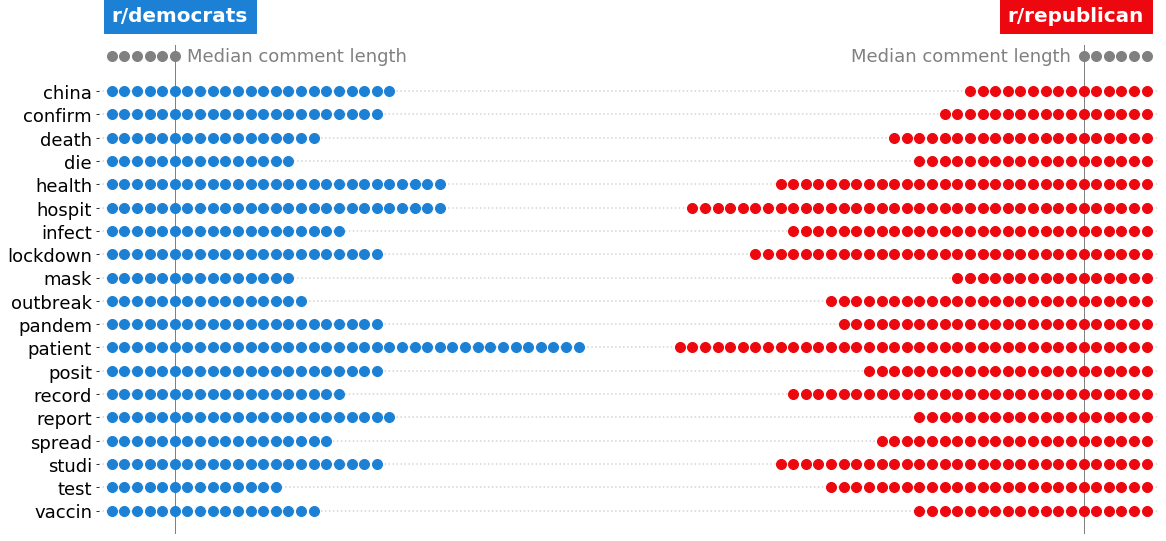

In [307]:
median_other_rep = dfrep[dfrep.covidcoef == 0].tokens.apply(len).median()
median_other_dem = dfdem[dfdem.covidcoef == 0].tokens.apply(len).median()

def HasCOVIDword(tokens):
    global word_i
    return(word_i in tokens)

MEDIANS = {}
for i, word_i in enumerate(token_names):
    
    median_wi_rep = dfrep[dfrep.tokens.apply(HasCOVIDword) == True].tokens.apply(len).median()
    median_wi_dem = dfdem[dfdem.tokens.apply(HasCOVIDword) == True].tokens.apply(len).median()
    MEDIANS[word_i] = {'rep' : median_wi_rep, 'dem' : median_wi_dem}
    
middlespace = 7
total_length = max([MEDIANS[wi]['rep'] + MEDIANS[wi]['dem'] for wi in MEDIANS.keys()]) + middlespace

sw = 100

fig, ax = plt.subplots(1,1,figsize = (19,9))
for i, word_i in enumerate(list(reversed(token_names))):

    m1 = MEDIANS[word_i]['dem']
    m2 = MEDIANS[word_i]['rep']
    range1 = range(int(m1))
    range2 = range(int(total_length - m2),int(total_length))
    ax.plot([-1000,1000],[i,i], lw = 1.5, ls = ':', c = 'lightgrey',zorder=0)
    ax.scatter(x=range1, y=[i for _ in range1], c = cdem, s = sw,zorder=10)
    ax.scatter(x=range2, y=[i for _ in range2], c = crep, s = sw,zorder=10)
    

m1 = median_other_dem
m2 = median_other_rep
range1 = range(int(m1))
range2 = range(int(total_length - m2),int(total_length))
top_i = len(token_names) + 0.5
ax.scatter(x=range1, y=[top_i for _ in range1], c = 'grey', s = sw)
ax.scatter(x=range2, y=[top_i for _ in range2], c = 'grey', s = sw)

ax.plot([m1-1,m1-1], [-100,100], c = 'grey', lw = 1)
ax.plot([total_length-m2,total_length-m2], [-100,100], c = 'grey', lw = 1)
  
ax.text(x=max(range1)+1,y=top_i, s='Median comment length',va='center',ha='left', fontsize = 18, c = 'grey')
ax.text(x=min(range2)-1,y=top_i, s='Median comment length',va='center',ha='right', fontsize = 18, c = 'grey')


ax.text(0, 21, 'r/democrats', color='white', fontsize = 20, fontweight = 'bold', bbox=dict(facecolor=cdem, edgecolor=cdem, pad=8.0))
ax.text(71, 21, 'r/republican', color='white', fontsize = 20, fontweight = 'bold', bbox=dict(facecolor=crep, edgecolor=crep, pad=8.0))

ax.set_ylim(-1,len(token_names) + 1)
ax.set_xlim(-1,total_length)

ax.set_yticks(range(len(token_names)))
ax.set_yticklabels(list(reversed(token_names)), fontsize=18)

ax.set_xticks([])
fig.patch.set_visible(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.savefig(img_folder + 'COMMENT_LENGTH.svg')  

In [184]:
from matplotlib.cbook import boxplot_stats

list4 = {'rep':pd.DataFrame(dictrep), 'dem':pd.DataFrame(dictdem)}

List_of_dfs = []
List_of_dfs_filtered = []
Q3 = {}
for i in ['rep', 'dem']:
    
    dfi = list4[i]
    Q3[i] = []
    # Finding the 3rd quantile to get only the outliers
    stats = boxplot_stats(dfi[controversy_topics].values)

    q3_lim = [s['whishi'] for s in stats]
    q3dict = {w:s for w,s in zip(controversy_topics, q3_lim)}

    baseline = 0
    for w in controversy_topics:
        
        dfw = dfi[['x', w]]
        min2 = np.sort(dfw[w].unique())[1]
        dfw[w] = dfw[w]/min2

        dfw['word'] = w
        dfw = dfw.rename(columns={w:'value'})
        dfw['baseline'] = baseline
        dfw['partisanship'] = i
        
        List_of_dfs.append(dfw)
        
        # selecting only outliers
        
        q3w = q3dict[w]/min2
        dfw = dfw[dfw['value'] > q3w]
        Q3[i].append(q3w)
        
        List_of_dfs_filtered.append(dfw)

        baseline += 1

df4 = pd.concat(List_of_dfs, axis=0)
df5 = pd.concat(List_of_dfs_filtered, axis=0)
df5['y_coord'] = df5['value'] + df5['baseline']

In [28]:
#ax = sns.violinplot(x="partisanship", y="value", data=df4)
#ax = sns.boxplot(x="partisanship", y="value", data=df4)
#ax = sns.boxplot(x="partisanship", y="value", data=df4)
#ax.set_yscale("log")

# bins = np.arange(0,35,1)
# fig, ax = plt.subplots(1,1,figsize=(8,2))
# plt.hist(df4[df4["partisanship"]=="dem"]["value"].reset_index(drop=True), alpha=0.6, label="Democrat", bins=bins)
# plt.hist(df4[df4["partisanship"]=="rep"]["value"].reset_index(drop=True), alpha=0.6, label="Republican", bins=bins)

# ax.set_ylim(0,100)

# plt.legend()
# plt.show()

Normalizing by subreddit

In [185]:
fact4 = {'rep' : 2*list4['rep'].shape[0]/(list4['dem'].shape[0] + list4['rep'].shape[0]),
           'dem' : 2*list4['dem'].shape[0]/(list4['dem'].shape[0] + list4['rep'].shape[0])}
df5[df5.partisanship == 'rep']['value'] = df5[df5.partisanship == 'rep']['value'].apply(lambda x : x/fact4['rep'])
df5[df5.partisanship == 'dem']['value'] = df5[df5.partisanship == 'dem']['value'].apply(lambda x : x/fact4['dem'])

In [303]:
Buttons = []

p5 = figure(x_range = (0,366), y_range = (-2,20), plot_width = 1200, plot_height = 600, tools = '', 
            title = 'Frequency surges timeline (2020)')

df5['y_coord_f'] = df5['y_coord']*0.01
df5['color'] = df5.partisanship.map({'rep' : crep, 'dem' : cdem})
df5['size'] = 1.5*df5['value']


labels_toggle = ['r/republican','r/democrats']
for i,pan in enumerate(['rep','dem']):
    source5 = ColumnDataSource(df5[df5.partisanship == pan])
    squares = p5.square(x='x', y='baseline', size = 'size', source = source5, color = 'color')
    
    toggle1 = Toggle(label=labels_toggle[i], button_type="default", active=True, default_size = 120)
    toggle1.js_link('active', squares, 'visible')
    Buttons.append(toggle1)

for i in range(19):    
    p5.line([-5,400],[i,i], line_color = 'grey', line_width = 1, line_dash = 'dotted', level = 'underlay')
    
color_event = 'black'

# Adding vertical lines for events
event_lines = []
# 7 / 7-Jan / Chinese authorities report coronavirus
# 20 / 20-Jan / First reported COVID case in the US
# 73 / 13-Mar / Major lockdown in Europe
# 106 / 15-Apr / Europe surpasses 1mil death
# 156 / 
# 196 / 14-Jul / US officially surpasses 120k deaths of COVID-19
# 255 / 9-11/
# 285 / 11-Oct / Trump test positive    
# 308 / 13-Nov / US elections
# 343 / 8-Dec / First person gets vaccinated
Events = [7,20,73,106, 196, 255,285,308,343]
for event in Events:
    event_lines.append(Span(location=event, dimension='height', line_color=color_event, line_alpha = 0.5, 
                            line_width=1, line_dash = 'solid', level = 'underlay'))
    p5.renderers.extend(event_lines)
    

    
Events_description = ['Chinese authorities report coronavirus',
                     'First reported COVID case in the US',
                     'Major lockdowns worldwide',
                     'Europe surpasses 1mil death of COVID-19',
                     'US officially surpasses 120k deaths of COVID-19',
                     '19th Anniversary commemoration of 9/11',
                     'Donald Trump tests positive of COVID-19',
                     '59th US presidential elections',
                     'First person gets vaccinated for COVID-19']

Events_date = ['7-Jan', '20-Jan','13-Mar','15-Apr','14-Jul','11-Sep','11-Oct','13-Nov','8-Dec']
    
    
TOOLTIPS_title = """
    <div>
        <div>
            <span style="font-size: 18px; font-weight: bold;">@date</span>
        </div>
        <div style="width:200px; height: 30%;">
            <span style="font-size: 16px; color: black;">@description</span>
        </div>
    </div>
"""

dfdfdf = pd.DataFrame({'x' : Events,
                       'y' : [19.8 for _ in Events],
                       'date' : Events_date,
                       'description' : Events_description})
r_events = p5.inverted_triangle(x='x', y = 'y', 
                     source = ColumnDataSource(dfdfdf), line_width = None, 
                     line_color = color_event, fill_color = color_event, size = 14)

# Adding hover tool for events    
hover1 = HoverTool(tooltips=TOOLTIPS_title,renderers = [r_events], mode = 'vline')
p5.tools.append(hover1)   


p5.ygrid.ticker = list(range(19))
#p5.ygrid.grid_line_color = 'lightgrey'
#p5.ygrid.grid_line_dash = 'dotted'
p5.grid.visible = False

p5.background_fill_color = 'seashell'
p5.background_fill_color = None
p5.outline_line_color = 'black'
p5.outline_line_width = 2
p5.axis.visible = False

p5.title.text_font_size = '18pt'
p5.title.text_color = 'black'


p5.yaxis.visible = True
yaxis_tickpos = list(range(0,len(controversy_topics)))
p5.yaxis.ticker = yaxis_tickpos
p5.yaxis.major_label_overrides = {(pos):lab for pos,lab in enumerate(controversy_topics)}
p5.yaxis.major_label_text_font_size = '18pt'
p5.yaxis.major_label_text_color = 'black'
p5.yaxis.major_tick_line_color = 'black'
p5.yaxis.axis_line_color = None


text1 = Text(x='x', y='y', text="text", text_font_size = '18pt', y_offset = 10, x_offset = 0, 
              text_color = 'black', text_baseline = 'bottom', text_align = 'right', text_font_style = 'normal')

p5.add_glyph(ColumnDataSource(dict(x=[-10 for _ in controversy_topics],
                                   y=[h for h in range(len(controversy_topics))],
                                   text=controversy_topics)), text1)

output_file(filename=img_folder + "SURGE_TIMELINE.html", title="")
save(column(p5,row(Buttons)))

'/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/web/SURGE_TIMELINE.html'

In [304]:
from sklearn.linear_model import LinearRegression
from math import ceil


items = [] # items for legend
lines ={} # bar-information for plotting
days = list(range(106))

TOOLS = ""

List_of_plots = []

datest['zero'] = 0
c1 = 'goldenrod'
c2 = cneut
c3 = 'black'

impact_metric = 'num_comments'
Nobs = min(N_rep, N_dem)

NEUTRALITY = {}


# Generating example/first plot
indx = 0
w_i = controversy_topics[indx]

y_rep = [j/N_rep for j in topww[w_i][:Nobs]]
y_dem = [j/N_dem for j in topww1[w_i][:Nobs]]

max_count = max(y_rep + y_dem)
maxxy = 1.05*max_count #+ 1
minxy = -0.05*max_count

X_rep = np.array(y_rep).reshape(-1,1)
reg = LinearRegression(fit_intercept = False).fit(X=X_rep, y=y_dem)
R2 = reg.score(X=X_rep, y=y_dem)
slope = reg.coef_[0]
NEUTRALITY[w_i] =  R2, np.exp(R2)*np.tanh(-(slope-1))


p_1 = figure(plot_width= 350 + 400, plot_height=350,
             title = '', 
             x_range=(minxy,maxxy),y_range = (minxy,maxxy), tools = TOOLS)

center_xy = (maxxy+minxy)/2

label_i = Label(x=center_xy, y=center_xy, text=w_i, text_font_size = '28pt',
                border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                background_fill_color=None, background_fill_alpha=1.0, text_color = 'black',
                text_baseline = 'middle', text_align = 'center',  text_alpha = 1,
                level='underlay')

p_1.add_layout(label_i)

p_1.line(y=[-10,10], x=[-10,10], color=c2, alpha = 1, line_width = 1.5, line_dash = 'dashed')
r = p_1.scatter(x=y_rep, y=y_dem, color=c1, alpha = 1, size=9, line_color = c3)


legend = Legend(items=[('Monthly mentions of "china" in (*)', [r])])
legend.click_policy="mute"
legend.border_line_width = 0
legend.label_text_font_size = '16pt'
p_1.add_layout(legend, 'right')


# Adjusting plot parameters
#p.x_range.range_padding = 0.05
p_1.xaxis.axis_label = "(*) r/republican"
p_1.yaxis.axis_label = "(*) r/democrats"
p_1.xaxis.visible = True
p_1.yaxis.visible = True
p_1.yaxis.axis_line_width = 1
p_1.yaxis.ticker = []
p_1.xaxis.axis_line_width = 1
p_1.xaxis.ticker = []

p_1.axis.axis_label_text_font_size = '16pt'
p_1.axis.axis_label_text_font_style = 'normal'
p_1.axis.axis_label_text_color = 'black'
p_1.axis.axis_line_width = 1.5

p_1.grid.visible = False
p_1.background_fill_color = 'white'
p_1.background_fill_alpha = 1

p_1.outline_line_color = 'black'
p_1.border_fill_color = None

p_1.background_fill_color = "seashell"

# Generating the rest
for indx,w_i in enumerate(controversy_topics[1:]):
    
    y_rep = [j/N_rep for j in topww[w_i][:Nobs]]
    y_dem = [j/N_dem for j in topww1[w_i][:Nobs]]
    
    max_count = max(y_rep + y_dem)
    maxxy = 1.05*max_count #+ 1
    minxy = -0.05*max_count
    
    X_rep = np.array(y_rep).reshape(-1,1)
    reg = LinearRegression(fit_intercept = False).fit(X=X_rep, y=y_dem)
    R2 = reg.score(X=X_rep, y=y_dem)
    slope = reg.coef_[0]
    NEUTRALITY[w_i] =  R2, np.exp(R2)*np.tanh(-(slope-1))
        
    
    p = figure(plot_width= 150, plot_height=150, 
               title = None, x_range=(minxy,maxxy),y_range = (minxy,maxxy), tools = TOOLS)
    
    center_xy = (maxxy+minxy)/2
    
    label_i = Label(x=center_xy, y=center_xy, text=w_i, text_font_size = '20pt',
                    border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                    background_fill_color=None, background_fill_alpha=1.0, text_color = 'black',
                    text_baseline = 'middle', text_align = 'center', text_alpha = 1,
                    level='underlay')

    p.add_layout(label_i)
    
    p.line(y=[-10,10], x=[-10,10], color=c2, alpha = 1, line_width = 1.5, line_dash = 'dashed')
    r = p.scatter(x=y_rep, y=y_dem, color=c1, alpha = 1, size=7, line_color = c3)
    

    # Adjusting plot parameters
    #p.x_range.range_padding = 0.05
    p.xaxis.axis_label = ""
    p.yaxis.axis_label = ""
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.grid.visible = False
    p.background_fill_color = 'white'
    p.background_fill_alpha = 1
    
    p.outline_line_color = 'black'
    p.background_fill_color = None
    p.border_fill_color = None
    
    p.background_fill_color = "seashell"
    
    List_of_plots.append(p)
    
    
p_rest = gridplot(List_of_plots, ncols=6)

#show(p_a)

output_file(filename=img_folder + "METRIC.html", title="")
save(column(p_1, p_rest))

'/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/web/METRIC.html'

A covid word would be totally neutral if the slope computed above is equal to 1. However, the closer to zero, the more "republican" the word is. Analogously, the higher the value of n is, the more "democrat" the word is.

### Rate of change

In [188]:
df2019_dem = ReadSubreddit('democrats', agg_step = 'month', year = 2019)
df2019_rep = ReadSubreddit('republican', agg_step = 'month', year = 2019)

In [189]:
df2019_dem = df2019_dem.drop(df2019_dem[df2019_dem.author == 'AutoModerator'].index)
df2019_rep = df2019_rep.drop(df2019_rep[df2019_rep.author == 'AutoModerator'].index)

In [190]:
def RateChange(word, d2019, d2020):
    
    n19 = d2019.comments.apply(lambda x: x.count(word)).sum()/d2019.shape[0]
    n20 = d2020.comments.apply(lambda x: x.count(word)).sum()/d2020.shape[0]
    
    return n20/(n20 + n19)

CHANGE_dem = {}
CHANGE_rep = {}
for w_i in token_names:
    rc_i = RateChange(w_i, d2019=df2019_dem, d2020 =dfdem)
    rc_j = RateChange(w_i, d2019=df2019_rep, d2020 =dfrep)

    CHANGE_dem[w_i] = rc_i
    CHANGE_rep[w_i] = rc_j
    
    #print(w_i, rc_i, rc_j)
    

In [191]:
df3 = pd.DataFrame.from_dict({'words' : token_names,'rc_dem' : CHANGE_dem.values(),
                              'rc_rep' : CHANGE_rep.values(),
                              'n' : [n[1] for n in NEUTRALITY.values()]}, orient='index').transpose()

df3['rc'] = df3[['rc_dem','rc_rep']].mean(axis=1)
df3.head()

,words,rc_dem,rc_rep,n,rc
0,china,0.511348,0.727817,0.900865,0.619583
1,confirm,0.601407,0.560698,-0.0160981,0.581053
2,death,0.650954,0.685967,0.525926,0.668460
3,die,0.558498,0.510936,0.295122,0.534717
4,health,0.384625,0.468404,-0.0767691,0.426515


In [35]:
# Reading
df3 = pd.read_csv('./data/df3.csv')
#dfdem = pd.read_csv('./data/dfdem.csv')
#dfrep = pd.read_csv('./data/dfrep.csv')
df2019_dem = pd.read_csv('./data/df2019_dem.csv')
df2019_rep = pd.read_csv('./data/df2019_rep.csv')

#dfrep_agg = pd.read_csv('./data/dfrep_agg.csv',header = True)
#dfdem_agg = pd.read_csv('./data/dfdem_agg.csv',header = True)

https://www.reddit.com/r/pushshift/comments/ayvut7/how_do_you_link_the_comments_with_their/

t1_ comment to comment
t3_ comment to post

In [192]:
colname = 'parent_id'

dfx = dfrep
dft1 = dfx[dfx[colname].str.contains("t1_")]
values = dft1[colname].value_counts(dropna=False).keys().tolist()
counts = dft1[colname].value_counts(dropna=False).tolist()
#value_dict = dict(zip(values, counts))

In [37]:
# df2019_rep = pd.read_csv('./data/df2019_rep.csv')
# df2019_dem = pd.read_csv('./data/df2019_dem.csv')

In [197]:
from bokeh.models import CustomJS, Range1d, LabelSet
from bokeh.models.widgets import Div

N = list(NEUTRALITY.values())
C = list(CHANGE_dem.values())

event = 0.5

xmax = 1.3
xmin = -1.3

df3['nn'] = 2*(df3.n - df3.n.min())/(df3.n.max()-df3.n.min()) -1

# create a new plot with the toolbar below
p = figure(plot_width=700, plot_height=700, x_range=(xmin-0.2,xmax+0.2) ,y_range = (-0.1,1.1),
           title=None, toolbar_location="above",toolbar_sticky=False, tools = 'wheel_zoom,reset,pan')

source = ColumnDataSource(data=df3)


image_bkg = path.join('.','images',''.join(['repdem3.png']))
r_image = p.image_url(url=[image_bkg], x=-1.2, y=0.5, w=50, h=50, global_alpha = 1, anchor = 'center',level='underlay')


p.line([-10,10],[0.5,0.5], line_color = 'lightgrey', line_width = 1)
p.line([0,0],[-10,10], line_color = 'lightgrey', line_width = 1)

#vline = Span(location=0.5, dimension='width', line_color='lightgrey',
#             line_width=1, line_dash = 'solid', level = 'underlay')
#hline = Span(location=event, dimension='height', line_color='lightgrey',
#             line_width=1, line_dash = 'solid', level = 'underlay')
#p.renderers.extend([hline])


glyph_text = Text(x='n', y='rc', text="words", 
                  x_offset = 6, y_offset = 10, 
                  text_align = 'center', text_baseline = 'middle', 
                  angle=0, text_font_size = '20pt', text_color='black', text_alpha = 1, text_font_style = 'bold')
r_text = p.add_glyph(source, glyph_text)


# x_ticks = [xmin, xmax]
# y_ticks = [0, 1]
# x_labels = ['Democrat', 'Republican']
# p.xaxis.ticker = x_ticks
# p.yaxis.ticker = y_ticks

# p.xaxis.axis_label = "Partisanship"
# p.yaxis.axis_label = "Rate of change 2019/2020"

# p.xaxis.major_label_overrides = {xmin:'Democrat', xmax : 'Republican'}
# p.yaxis.major_label_overrides = {0:'2019', 1 : '2020'}

# p.xaxis.major_label_text_font_size = '18pt'
# p.yaxis.major_label_text_font_size = '18pt'

# p.xaxis.major_tick_line_width = 4
# p.yaxis.major_tick_line_width = 4

p.xaxis.visible = False
p.yaxis.visible = False


p.outline_line_color = 'black'
p.outline_line_width = 4


# div = Div(text='', width=300)
# p.js_on_event('tap', CustomJS(args={'src': source, 'div': div}, code="""
#     if (src.selected.indices.length == 0){
#         div.text = '';
#     }
# """))


p_left = figure(plot_width=80, plot_height=700, x_range=(0,1) ,y_range = (0,1), title=None, tools = '', toolbar_location="above")
p_left.line([],[])
for lr, dr, y_i, offy_i in  zip(['left','right','center'],['2019', '2020','Popular word in'],[0,1,0.5],[-50,50,0]):
    glyph_text = Text(x='x', y='y', text="word", 
                      x_offset = 0, y_offset = offy_i, 
                      text_align = 'center', text_baseline = 'middle', 
                      angle=np.pi/2, text_font_size = '20pt', text_color='black', text_alpha = 1, text_font_style = 'normal')
    p_left.add_glyph(ColumnDataSource(pd.DataFrame({'x' : [0.5], 'y' : [y_i],'word' : [dr]})), glyph_text)
    p_left.scatter(y = [0.02 + 0.3],x = [0.5],marker = 'triangle', line_color = None, fill_color = 'black', size = 18, angle = np.pi)
    p_left.scatter(y = [0.98 - 0.3],x = [0.5],marker = 'triangle', line_color = None, fill_color = 'black', size = 18,  angle = 0)



p_bottom = figure(plot_width=700+80, plot_height=80, x_range=(0,1) ,y_range = (0,1), title=None, tools = '', toolbar_location="below")
p_bottom.line([],[])

for lr, dr, x_i, offx_i in  zip(['left','right','center'],['r/democrats', 'r/republican','Popular word in'],[80/780,1,0.54],[10,-10,0]):
    glyph_text = Text(x='x', y='y', text="word", 
                      x_offset = offx_i, y_offset = 0, 
                      text_align = lr, text_baseline = 'middle', 
                      angle=0, text_font_size = '20pt', text_color='black', text_alpha = 1, text_font_style = 'normal')
    p_bottom.add_glyph(ColumnDataSource(pd.DataFrame({'x' : [x_i], 'y' : [0.5],'word' : [dr]})), glyph_text)
    p_bottom.scatter(x = [1.02*(80/780) + 0.3],y = [0.5],marker = 'triangle', line_color = None, fill_color = 'black', size = 18, angle = np.pi/2)
    p_bottom.scatter(x = [0.98 - 0.3],y = [0.5],marker = 'triangle', line_color = None, fill_color = 'black', size = 18,  angle = -np.pi/2)


p_left = empty_canvas(p_left)
p_bottom = empty_canvas(p_bottom)


show(layout([
    [p_left, p],
    [p_bottom]
]))

In [ ]:
# Writing
#df3.to_csv('./data/df3.csv',header = True)
dfdem.to_csv('./data/dfdem.csv',header = True)
dfrep.to_csv('./data/dfrep.csv',header = True)
topww.to_csv('./data/topww.csv',header = True)
topww1.to_csv('./data/topww1.csv',header = True)
df2019_dem.to_csv('./data/df2019_dem.csv',header = True)
df2019_rep.to_csv('./data/df2019_rep.csv',header = True)

dfrep_agg.to_csv('./data/dfrep_agg.csv',header = True)
dfdem_agg.to_csv('./data/dfdem_agg.csv',header = True)